# GP

In [5]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [6]:
# %matplotlib inline
#%matplotlib widget


# Setup environment collect data

In [7]:
# =========================================================
# Cell 1 — MonsterTruck environment setup (MuJoCo, radians)
# Utilities, constants, and policies ONLY (no collection here)
# =========================================================
import os, math, time
import numpy as np
import mujoco

# ------------------- Global config -------------------
SEED = 0
rng = np.random.default_rng(SEED)

XML_PATH   = "monstertruck.xml"   # update if needed
FRAME_SKIP = 10                   # sim steps per control
ACTION_LOW, ACTION_HIGH = -1.0, 1.0

# Sign convention: + when pitching toward the head direction
PITCH_SIGN = +1   # flip to -1 if your model's "forward" comes out negative

# Success hysteresis (now in radians)
SUCCESS_ENTER_RAD    = np.deg2rad(178.0)
SUCCESS_RELEASE_RAD  = np.deg2rad(176.5)
MAX_UPRIGHT_RATE_RAD = np.deg2rad(60.0)
HOLD_NEEDED          = 2

# ------------------- Angle helpers (radians) -------------------
def clip(v, lo, hi):
    return lo if v < lo else (hi if v > hi else v)

def angdiff_rad(curr, prev):
    """Minimal signed angle diff in radians, (-pi, pi]."""
    return ((curr - prev + np.pi) % (2.0 * np.pi)) - np.pi

def get_signed_flip_rad(data, body_id, roof_is_neg_z=True):
    """
    Signed flip angle φ [rad] with your convention:
      0 = upside-down, ±π = upright.
      Positive when pitching toward the head (forward), negative otherwise.

    Numerically-stable via atan2(||z×r||, z·r). Sign from (z×r)·y (about pitch axis).
    """
    R = data.xmat[body_id].reshape(3, 3)     # body->world rotation
    z_w = np.array([0.0, 0.0, 1.0], float)   # world up

    body_z_world = R[:, 2]
    r_w = -body_z_world if roof_is_neg_z else body_z_world  # roof normal in world
    y_w =  R[:, 1]  # body Y (pitch axis) expressed in world

    v = np.cross(z_w, r_w)                   # perpendicular to both
    c = float(np.dot(z_w, r_w))              # cos-like term
    s_axis = float(np.dot(v, y_w))           # sign wrt pitch axis (forward/backward)
    theta = math.atan2(np.linalg.norm(v), clip(c, -1.0, 1.0))  # [0, π] in radians

    # Persistent sign memory to avoid flicker near 0
    if not hasattr(get_signed_flip_rad, "_flip_sign"):
        get_signed_flip_rad._flip_sign = 0.0
    if theta > np.deg2rad(0.5) and abs(s_axis) > 1e-12:
        get_signed_flip_rad._flip_sign = 1.0 if (PITCH_SIGN * s_axis) > 0.0 else -1.0

    sgn = get_signed_flip_rad._flip_sign if get_signed_flip_rad._flip_sign != 0.0 else 1.0
    return sgn * theta

# ------------------- Reset / control helpers -------------------
def reset_state(model, data):
    """Upside-down spawn with tiny jitter."""
    mujoco.mj_resetData(model, data)
    data.qpos[:3] = np.array([0.0, 0.0, 0.2])  # slight above ground
    data.qvel[:]  = 0.0
    data.qpos[3:7] = np.array([0.0, 1.0, 0.0, 0.0])  # 180° about X (upside-down)
    mujoco.mj_forward(model, data)
    # reset flip-sign memory
    get_signed_flip_rad._flip_sign = 0.0

def find_throttle_ids(model):
    ids = []
    for name in ["front_left_motor", "front_right_motor",
                 "rear_left_motor", "rear_right_motor"]:
        aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
        if aid != -1:
            ids.append(aid)
    if not ids:
        ids = list(range(model.nu))  # fallback: drive all actuators
    return ids

def apply_throttle(data, ids, u):
    if data.ctrl is not None and data.ctrl.size > 0:
        data.ctrl[:] = 0.0
        for aid in ids:
            data.ctrl[aid] = u

# ------------------- Continuous policies (use radians) -------------------
def random_policy():
    return float(rng.uniform(ACTION_LOW, ACTION_HIGH))

def swing_cont_policy(phi_rad, omega_rad, k=0.7, bias=0.0, noise_std=0.15):
    """
    Continuous 'swing' throttle (radians):
      - scales with angular rate via tanh(·)
      - optional small Gaussian exploration
    Returns: float in [-1, 1]
    """
    base = k * np.tanh(omega_rad / 3.0) + bias * np.sign(omega_rad)
    a = base + noise_std * rng.normal()
    return float(np.clip(a, ACTION_LOW, ACTION_HIGH))


# Dynamics from GP

In [8]:
# =========================================================
# Cell 2 — Active data collection (radians, occupancy-targeted)
# Produces:
#   phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s
# Needs Cell 1 (radian helpers + MuJoCo utils) executed first.
# =========================================================
import os, math
import numpy as np
import mujoco

TOTAL_STEPS =100_000          # total macro-steps to log
FRAME_LIMIT_PER_TARGET = 60    # retarget if we haven't hit bin in this many steps

# Histogram grid for occupancy
BINS_PHI   =80
BINS_OMEGA = 80
OMEGA_LIM  = 30.0              # rad/s range for binning (values beyond are clamped)

# Targeting distribution p ∝ (count + ε)^(-α)
ALPHA = 1.2
EPS   = 1.0

# PD controller toward bin center
K_PHI = 1.6                     # proportional on angle error (rad)
K_OMG = 0.35                    # proportional on rate error (rad/s)

# Success hysteresis (radian fallback to your deg constants)
SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(globals().get("SUCCESS_ENTER_DEG",    178.0)))
SUCCESS_RELEASE_RAD  = globals().get("SUCCESS_RELEASE_RAD",  np.deg2rad(globals().get("SUCCESS_RELEASE_DEG",  176.5)))
MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(globals().get("MAX_UPRIGHT_RATE_DEG", 60.0)))
HOLD_NEEDED          = globals().get("HOLD_NEEDED", 2)

def _to_scalar(a):
    try:
        return float(a)
    except (TypeError, ValueError):
        arr = np.asarray(a).reshape(-1)
        return 0.0 if arr.size == 0 else float(arr[0])

def collect_active_occ(n_steps=TOTAL_STEPS):
    if not os.path.exists(XML_PATH):
        raise FileNotFoundError(f"Cannot find {XML_PATH}.")
    model = mujoco.MjModel.from_xml_path(XML_PATH)
    data  = mujoco.MjData(model)
    dt = model.opt.timestep if model.opt.timestep > 0 else 0.001

    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
    if body_id == -1:
        raise RuntimeError("Body 'chassis' not found in XML.")
    throttle_ids = find_throttle_ids(model)

    # --- bin edges / helpers ---
    phi_edges = np.linspace(-np.pi, np.pi, BINS_PHI + 1)
    omg_edges = np.linspace(-OMEGA_LIM, OMEGA_LIM, BINS_OMEGA + 1)
    phi_cent  = 0.5 * (phi_edges[:-1] + phi_edges[1:])
    omg_cent  = 0.5 * (omg_edges[:-1] + omg_edges[1:])
    phi_bw    = (phi_edges[1] - phi_edges[0])
    omg_bw    = (omg_edges[1] - omg_edges[0])
    PHI_TOL   = 0.5 * phi_bw
    OMG_TOL   = 0.5 * omg_bw

    def _bin_indices(phi, omg):
        ip = int(np.clip(np.digitize(phi, phi_edges) - 1, 0, BINS_PHI   - 1))
        io = int(np.clip(np.digitize(omg, omg_edges) - 1, 0, BINS_OMEGA - 1))
        return ip, io

    def _choose_target(counts):
        weights = (counts + EPS) ** (-ALPHA)
        p = (weights / np.sum(weights)).ravel()
        idx = np.random.choice(p.size, p=p)
        io, ip = np.unravel_index(idx, counts.shape)
        return phi_cent[ip], omg_cent[io], ip, io

    def _pd_to_target(phi, omg, phi_t, omg_t=0.0):
        e_phi = angdiff_rad(phi_t, phi)   # minimal signed angle error
        e_omg = omg_t - omg
        u = K_PHI * e_phi + K_OMG * e_omg
        return float(np.clip(np.tanh(u), -1.0, 1.0))  # smooth saturation

    # --- logs ---
    phi_log, omg_log, act_log, dphi_log, domg_log = [], [], [], [], []
    counts = np.zeros((BINS_OMEGA, BINS_PHI), dtype=np.int32)

    # === One long run with periodic retargeting ===
    reset_state(model, data)

    # prime ω with a zero-action macro-step
    phi_prev = get_signed_flip_rad(data, body_id)
    apply_throttle(data, throttle_ids, 0.0)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)
    phi_now  = get_signed_flip_rad(data, body_id)
    omg_prev = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
    phi_prev = phi_now

    # initial target
    phi_t, omg_t, ip_t, io_t = _choose_target(counts)
    steps_on_target = 0
    hold = 0

    for _ in range(n_steps):
        # occupancy update from current state
        ip, io = _bin_indices(phi_prev, np.clip(omg_prev, -OMEGA_LIM, OMEGA_LIM))
        counts[io, ip] += 1

        # retarget if reached or stuck
        reached = (abs(angdiff_rad(phi_prev, phi_t)) < PHI_TOL) and (abs(omg_prev - omg_t) < OMG_TOL)
        if reached or steps_on_target >= FRAME_LIMIT_PER_TARGET:
            phi_t, omg_t, ip_t, io_t = _choose_target(counts)
            steps_on_target = 0

        # PD action toward the chosen sparse bin
        a = _pd_to_target(phi_prev, omg_prev, phi_t, omg_t)
        a = _to_scalar(a)

        # apply and step physics
        apply_throttle(data, throttle_ids, a)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

        # measure next state
        phi_now  = get_signed_flip_rad(data, body_id)
        omg_now  = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)

        # log sample (radians)
        phi_log.append(float(phi_prev))
        omg_log.append(float(omg_prev))
        act_log.append(float(a))
        dphi_log.append(float(angdiff_rad(phi_now, phi_prev)))
        domg_log.append(float(omg_now - omg_prev))

        # success hysteresis → reset for diversity
        if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omg_now) <= MAX_UPRIGHT_RATE_RAD):
            hold += 1
        elif abs(phi_now) < SUCCESS_RELEASE_RAD:
            hold = 0
        if hold >= HOLD_NEEDED:
            reset_state(model, data)
            phi_prev = get_signed_flip_rad(data, body_id)
            omg_prev = 0.0
            hold = 0
            # new target after reset
            phi_t, omg_t, ip_t, io_t = _choose_target(counts)
            steps_on_target = 0
            continue

        # slide window
        phi_prev, omg_prev = phi_now, omg_now
        steps_on_target += 1

    # pack arrays
    phi_arr  = np.asarray(phi_log,  dtype=np.float32)
    omg_arr  = np.asarray(omg_log,  dtype=np.float32)
    act_arr  = np.asarray(act_log,  dtype=np.float32)
    dphi_arr = np.asarray(dphi_log, dtype=np.float32)
    domg_arr = np.asarray(domg_log, dtype=np.float32)

    # coverage summary
    hit_bins = np.count_nonzero(counts)
    print(f"[Active-Occ] visited bins: {hit_bins} / {counts.size} "
          f"({100.0*hit_bins/counts.size:.1f}%), min count={counts[counts>0].min() if hit_bins else 0}")

    return phi_arr, omg_arr, act_arr, dphi_arr, domg_arr, counts, (phi_edges, omg_edges)

# ---- Run active collection once (returns same 5 arrays used by GP/viz) ----
phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s, occ_counts, (phi_edges, omg_edges) = collect_active_occ()

# quick ranges print
def _rng(a): return float(np.min(a)), float(np.max(a))
print("Ranges:",
      "ϕ", _rng(phi_rad),
      "ω", _rng(omega_rad_s),
      "u", _rng(act))


[Active-Occ] visited bins: 1478 / 6400 (23.1%), min count=1
Ranges: ϕ (-3.140716791152954, 3.141073703765869) ω (-313.0645446777344, 314.09686279296875) u (-1.0, 1.0)


In [9]:
# # =========================================================
# # Cell 2 — Active data collection v2 (radians, occupancy-targeted)
# # Focus on sparse (ϕ, ω) bins; log only inside the active target bin.
# # Produces:
# #   phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s
# # Also returns: occ_counts, (phi_edges, omg_edges)
# # Needs Cell 1 (radian helpers + MuJoCo utils) executed first.
# # =========================================================
# import os, math
# import numpy as np
# import mujoco
#
# # ---- dataset size ----
# TARGET_LOGS = 100_000          # number of ACCEPTED samples to record
#
# # ---- grid & targeting ----
# BINS_PHI, BINS_OMEGA = 60, 60  # phase-plane grid
# HALO_RADIUS          = 0       # 0=only target bin; 1=also accept 8 neighbors
# EPS                  = 1.0     # smoothing in (count+EPS)^(-alpha)
#
# # ---- controller & retargeting ----
# K_PHI, K_OMG             = 1.6, 0.35   # PD toward target bin center
# FRAME_LIMIT_PER_TARGET   = 40          # give up and retarget if not reached
# SEED_STEPS               = 5000        # quick seed to estimate ω-range
# COLLECT_FRAME_SKIP       = FRAME_SKIP  # reuse your global, or set e.g. 5/8/10
#
# # ---- multi-round alpha schedule (start gentle, end aggressive) ----
# ROUNDS         = 3
# ROUND_FRACS    = (0.4, 0.35, 0.25)  # fractions of TARGET_LOGS per round
# ALPHA_SCHEDULE = (0.9, 1.2, 1.6)
#
# # ---- fallback helpers if only-degree funcs exist in Cell 1 ----
# if "angdiff_rad" not in globals():
#     def angdiff_rad(curr, prev):  # [-π, π)
#         return ((curr - prev + np.pi) % (2*np.pi)) - np.pi
# if "get_signed_flip_rad" not in globals():
#     def get_signed_flip_rad(data, body_id):
#         return np.deg2rad(get_signed_flip_deg(data, body_id))
#
# # Success hysteresis in radians (fallback to deg globals from Cell 1)
# SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(globals().get("SUCCESS_ENTER_DEG",    178.0)))
# SUCCESS_RELEASE_RAD  = globals().get("SUCCESS_RELEASE_RAD",  np.deg2rad(globals().get("SUCCESS_RELEASE_DEG",  176.5)))
# MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(globals().get("MAX_UPRIGHT_RATE_DEG", 60.0)))
# HOLD_NEEDED          = globals().get("HOLD_NEEDED", 2)
#
# def _to_scalar(a):
#     try:
#         return float(a)
#     except (TypeError, ValueError):
#         arr = np.asarray(a).reshape(-1)
#         return 0.0 if arr.size == 0 else float(arr[0])
#
# def _pd_to_target(phi, omg, phi_t, omg_t=0.0):
#     e_phi = angdiff_rad(phi_t, phi)
#     e_omg = omg_t - omg
#     u = K_PHI*e_phi + K_OMG*e_omg
#     return float(np.clip(np.tanh(u), -1.0, 1.0))  # smooth saturation
#
# def _within_halo(ip, io, ip_t, io_t, r=HALO_RADIUS):
#     return (abs(ip - ip_t) <= r) and (abs(io - io_t) <= r)
#
# def collect_active_occ(target_logs=TARGET_LOGS):
#     if not os.path.exists(XML_PATH):
#         raise FileNotFoundError(f"Cannot find {XML_PATH}.")
#     model = mujoco.MjModel.from_xml_path(XML_PATH)
#     data  = mujoco.MjData(model)
#     dt = model.opt.timestep if model.opt.timestep > 0 else 0.001
#
#     body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
#     if body_id == -1:
#         raise RuntimeError("Body 'chassis' not found in XML.")
#     throttle_ids = find_throttle_ids(model)
#
#     # ---- quick seed to estimate reasonable ω-range (not logged) ----
#     reset_state(model, data)
#     phi_prev = get_signed_flip_rad(data, body_id)
#     apply_throttle(data, throttle_ids, 0.0)
#     for _ in range(COLLECT_FRAME_SKIP):
#         mujoco.mj_step(model, data)
#     phi_now  = get_signed_flip_rad(data, body_id)
#     omg_prev = angdiff_rad(phi_now, phi_prev) / (COLLECT_FRAME_SKIP*dt)
#     phi_prev = phi_now
#
#     omega_seen = []
#     for _ in range(SEED_STEPS):
#         a = _to_scalar(np.random.uniform(-1.0, 1.0))
#         apply_throttle(data, throttle_ids, a)
#         for _ in range(COLLECT_FRAME_SKIP):
#             mujoco.mj_step(model, data)
#         phi_now = get_signed_flip_rad(data, body_id)
#         omg_now = angdiff_rad(phi_now, phi_prev) / (COLLECT_FRAME_SKIP*dt)
#         omega_seen.append(abs(omg_now))
#         phi_prev, omg_prev = phi_now, omg_now
#
#     OMEGA_LIM = float(np.quantile(omega_seen, 0.995)) if omega_seen else 10.0
#
#     # ---- bin edges & helpers ----
#     phi_edges = np.linspace(-np.pi, np.pi, BINS_PHI + 1)
#     omg_edges = np.linspace(-OMEGA_LIM, OMEGA_LIM, BINS_OMEGA + 1)
#     phi_cent  = 0.5*(phi_edges[:-1] + phi_edges[1:])
#     omg_cent  = 0.5*(omg_edges[:-1] + omg_edges[1:])
#     phi_bw, omg_bw = (phi_edges[1]-phi_edges[0]), (omg_edges[1]-omg_edges[0])
#     PHI_TOL, OMG_TOL = 0.5*phi_bw, 0.5*omg_bw
#
#     def _bin_indices(phi, omg):
#         ip = int(np.clip(np.digitize(phi, phi_edges) - 1, 0, BINS_PHI   - 1))
#         io = int(np.clip(np.digitize(np.clip(omg, -OMEGA_LIM, OMEGA_LIM), omg_edges) - 1, 0, BINS_OMEGA - 1))
#         return ip, io
#
#     def _choose_target(counts, alpha):
#         weights = (counts + EPS) ** (-alpha)
#         p = (weights / np.sum(weights)).ravel()
#         idx = np.random.choice(p.size, p=p)
#         io, ip = np.unravel_index(idx, counts.shape)
#         return phi_cent[ip], omg_cent[io], ip, io
#
#     # ---- logs & occupancy ----
#     phi_log, omg_log, act_log, dphi_log, domg_log = [], [], [], [], []
#     counts = np.zeros((BINS_OMEGA, BINS_PHI), dtype=np.int32)
#
#     # re-prime for main collection
#     reset_state(model, data)
#     phi_prev = get_signed_flip_rad(data, body_id)
#     apply_throttle(data, throttle_ids, 0.0)
#     for _ in range(COLLECT_FRAME_SKIP):
#         mujoco.mj_step(model, data)
#     phi_now  = get_signed_flip_rad(data, body_id)
#     omg_prev = angdiff_rad(phi_now, phi_prev) / (COLLECT_FRAME_SKIP*dt)
#     phi_prev = phi_now
#
#     # split target_logs across rounds (fix rounding drift)
#     per_round = [int(fr*target_logs) for fr in ROUND_FRACS]
#     if sum(per_round) != target_logs:
#         per_round[-1] += (target_logs - sum(per_round))
#
#     last_report = 0
#     for ridx, (quota, alpha) in enumerate(zip(per_round, ALPHA_SCHEDULE), start=1):
#         accepted = 0
#         phi_t, omg_t, ip_t, io_t = _choose_target(counts, alpha)
#         steps_on_target = 0
#         hold = 0
#
#         while accepted < quota:
#             # steer toward target
#             a = _pd_to_target(phi_prev, omg_prev, phi_t, omg_t)
#             a = _to_scalar(a)
#
#             apply_throttle(data, throttle_ids, a)
#             for _ in range(COLLECT_FRAME_SKIP):
#                 mujoco.mj_step(model, data)
#
#             phi_now = get_signed_flip_rad(data, body_id)
#             omg_now = angdiff_rad(phi_now, phi_prev) / (COLLECT_FRAME_SKIP*dt)
#
#             # current bin (based on previous state)
#             ip, io = _bin_indices(phi_prev, omg_prev)
#
#             # accept ONLY if inside the target bin (or tiny halo)
#             if _within_halo(ip, io, ip_t, io_t, HALO_RADIUS):
#                 phi_log.append(float(phi_prev))
#                 omg_log.append(float(omg_prev))
#                 act_log.append(float(a))
#                 dphi_log.append(float(angdiff_rad(phi_now, phi_prev)))
#                 domg_log.append(float(omg_now - omg_prev))
#                 counts[io, ip] += 1
#                 accepted += 1
#
#                 # immediately pick a new sparse target with updated counts
#                 phi_t, omg_t, ip_t, io_t = _choose_target(counts, alpha)
#                 steps_on_target = 0
#             else:
#                 steps_on_target += 1
#                 if steps_on_target >= FRAME_LIMIT_PER_TARGET:
#                     phi_t, omg_t, ip_t, io_t = _choose_target(counts, alpha)
#                     steps_on_target = 0
#
#             # success-band reset for diversity
#             if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omg_now) <= MAX_UPRIGHT_RATE_RAD):
#                 hold += 1
#             elif abs(phi_now) < SUCCESS_RELEASE_RAD:
#                 hold = 0
#             if hold >= HOLD_NEEDED:
#                 reset_state(model, data)
#                 phi_prev = get_signed_flip_rad(data, body_id)
#                 omg_prev = 0.0
#                 hold = 0
#                 phi_t, omg_t, ip_t, io_t = _choose_target(counts, alpha)
#                 steps_on_target = 0
#                 continue
#
#             # slide window
#             phi_prev, omg_prev = phi_now, omg_now
#
#             # progress prints (global accepted count)
#             if (len(phi_log) - last_report) >= 20_000:
#                 last_report = len(phi_log)
#                 print(f"[Active-Occ α={alpha:.2f} | round {ridx}/{ROUNDS}] "
#                       f"{len(phi_log):,}/{target_logs:,} accepted…")
#
#     # pack outputs
#     phi_arr  = np.asarray(phi_log,  dtype=np.float32)
#     omg_arr  = np.asarray(omg_log,  dtype=np.float32)
#     act_arr  = np.asarray(act_log,  dtype=np.float32)
#     dphi_arr = np.asarray(dphi_log, dtype=np.float32)
#     domg_arr = np.asarray(domg_log, dtype=np.float32)
#
#     # coverage report
#     visited = counts > 0
#     v = counts[visited]
#     print(f"[Active-Occ] logs={len(phi_arr):,}  bins>0={np.count_nonzero(visited)}/{counts.size} "
#           f"({100.0*np.count_nonzero(visited)/counts.size:.1f}%)  "
#           f"min/med/max per visited bin = "
#           f"{(v.min() if v.size else 0)} / {(int(np.median(v)) if v.size else 0)} / {(v.max() if v.size else 0)}")
#
#     return phi_arr, omg_arr, act_arr, dphi_arr, domg_arr, counts, (phi_edges, omg_edges)
#
# # ---- run once ----
# phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s, occ_counts, (phi_edges, omg_edges) = collect_active_occ()
#
# # quick ranges
# def _rng(a): return float(np.min(a)), float(np.max(a))
# print("Ranges:",
#       "ϕ", _rng(phi_rad),
#       "ω", _rng(omega_rad_s),
#       "u", _rng(act))
# #

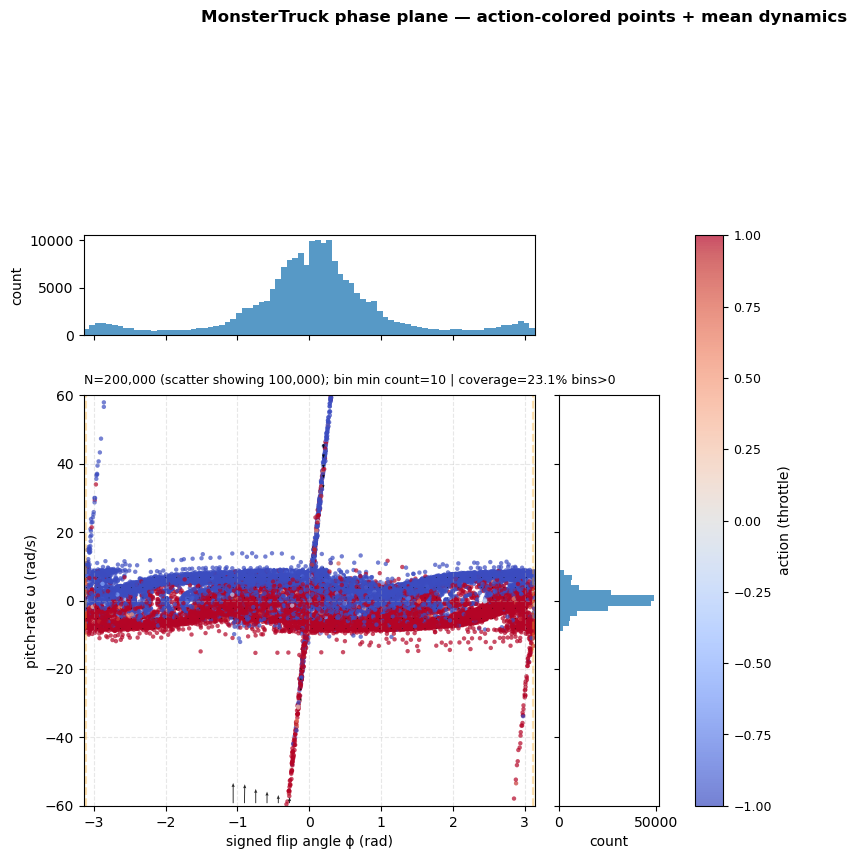

In [10]:
# =========================================================
# Cell 3 — Phase plane viz (radians) — robust to occ/bin shape
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ---------- Tunables ----------
BINS_PHI_FALLBACK   = 41
BINS_OMEGA_FALLBACK = 41
ARROW_STRIDE = 2
MIN_BIN_CNT  = 10
MAX_POINTS   = 100_000
DENS_BINS    = (80, 80)
Q_LO, Q_HI   = 0.5, 99.5

# Layout
PAD_TOP, PAD_RIGHT = 0.60, 0.24
HEIGHT_TOP, WIDTH_RIGHT = 1.0, 1.0
FIG_LEFT, FIG_RIGHT, FIG_BOTTOM, FIG_TOP = 0.08, 0.92, 0.10, 0.92
CBAR_PAD = 0.05

TITLE = "MonsterTruck phase plane — action-colored points + mean dynamics"
SUCCESS_ENTER = globals().get("SUCCESS_ENTER_RAD", np.deg2rad(178.0))

# ---------- Decide which grid to use ----------
have_occ = ('occ_counts' in globals())
have_edges = ('phi_edges' in globals()) and ('omg_edges' in globals())

use_occ_bins = False
if have_occ:
    ny, nx = occ_counts.shape  # ny = omega bins, nx = phi bins
    if have_edges and (len(phi_edges) == nx + 1) and (len(omg_edges) == ny + 1):
        phi_edges_plot = np.asarray(phi_edges)
        omg_edges_plot = np.asarray(omg_edges)
        use_occ_bins = True
    else:
        # Rebuild compatible edges from data percentiles and occ grid shape
        phi_lo, phi_hi = np.percentile(phi_rad,     [Q_LO, Q_HI])
        omg_lo, omg_hi = np.percentile(omega_rad_s, [Q_LO, Q_HI])
        phi_edges_plot = np.linspace(phi_lo, phi_hi, nx + 1)
        omg_edges_plot = np.linspace(omg_lo, omg_hi, ny + 1)
        use_occ_bins = True
else:
    # No occupancy grid available → fallback uniform bins from data
    phi_lo, phi_hi = np.percentile(phi_rad,     [Q_LO, Q_HI])
    omg_lo, omg_hi = np.percentile(omega_rad_s, [Q_LO, Q_HI])
    phi_edges_plot = np.linspace(phi_lo, phi_hi, BINS_PHI_FALLBACK + 1)
    omg_edges_plot = np.linspace(omg_lo, omg_hi, BINS_OMEGA_FALLBACK + 1)

# Use edges to set consistent limits and centers
phi_lo, phi_hi = float(phi_edges_plot[0]),  float(phi_edges_plot[-1])
omg_lo, omg_hi = float(omg_edges_plot[0]),  float(omg_edges_plot[-1])
BINS_PHI   = len(phi_edges_plot) - 1
BINS_OMEGA = len(omg_edges_plot) - 1
phi_centers = 0.5 * (phi_edges_plot[:-1] + phi_edges_plot[1:])
omg_centers = 0.5 * (omg_edges_plot[:-1] + omg_edges_plot[1:])

# ---------- Figure ----------
fig = plt.figure(figsize=(11.6, 9.2))
fig.subplots_adjust(left=FIG_LEFT, right=FIG_RIGHT, bottom=FIG_BOTTOM, top=FIG_TOP)
fig.suptitle(TITLE, y=0.985, fontsize=12, fontweight="bold")

# Main axis
ax = fig.add_axes([0.12, 0.12, 0.62, 0.62])

# Background: occupancy if available, else 2D density
if use_occ_bins and have_occ:
    H_bg = occ_counts.astype(float)  # shape (ny=omega, nx=phi) — DO NOT transpose
    ax.pcolormesh(phi_edges_plot, omg_edges_plot, H_bg, shading="auto", cmap="Greys", alpha=0.18)
else:
    H, xedges, yedges = np.histogram2d(
        phi_rad, omega_rad_s, bins=DENS_BINS, range=[[phi_lo, phi_hi], [omg_lo, omg_hi]]
    )
    ax.pcolormesh(xedges, yedges, H.T, shading="auto", cmap="Greys", alpha=0.15)

# Scatter (downsample if huge)
N = phi_rad.shape[0]
idx = np.random.default_rng(0).choice(N, size=MAX_POINTS, replace=False) if N > MAX_POINTS else slice(None)
norm = TwoSlopeNorm(vcenter=0.0, vmin=float(act.min()), vmax=float(act.max()))
pts = ax.scatter(
    phi_rad[idx], omega_rad_s[idx],
    c=act[idx], s=10, cmap="coolwarm", norm=norm, edgecolors="none", alpha=0.7
)

# Quiver: mean (Δφ, Δω) per bin aligned with edges in use
sum_dphi = np.zeros((BINS_PHI, BINS_OMEGA), dtype=np.float64)
sum_domg = np.zeros_like(sum_dphi)
count    = np.zeros_like(sum_dphi)

phi_idx = np.clip(np.digitize(phi_rad,     phi_edges_plot) - 1, 0, BINS_PHI   - 1)
omg_idx = np.clip(np.digitize(omega_rad_s, omg_edges_plot) - 1, 0, BINS_OMEGA - 1)

for i in range(phi_idx.size):
    sum_dphi[phi_idx[i], omg_idx[i]] += dphi_rad[i]
    sum_domg[phi_idx[i], omg_idx[i]] += domega_rad_s[i]
    count[phi_idx[i], omg_idx[i]]    += 1

mask = count >= MIN_BIN_CNT
U = np.zeros_like(sum_dphi); V = np.zeros_like(sum_dphi)
U[mask] = sum_dphi[mask] / count[mask]
V[mask] = sum_domg[mask] / count[mask]

sel = (np.arange(BINS_PHI)   % ARROW_STRIDE == 0)[:, None] & \
      (np.arange(BINS_OMEGA) % ARROW_STRIDE == 0)[None, :] & mask

mag = np.hypot(U[sel], V[sel])
p95 = np.percentile(mag[mag > 0], 95) if np.any(mag > 0) else 1.0
desired_len = 0.12 * (phi_hi - phi_lo)
quiver_scale = (p95 / desired_len) if p95 > 0 else 1.0

Xg, Yg = np.meshgrid(phi_centers, omg_centers, indexing="ij")
ax.quiver(
    Xg[sel], Yg[sel], U[sel], V[sel],
    angles="xy", scale_units="xy", scale=quiver_scale,
    width=0.002, headwidth=3.5, headlength=4.5, headaxislength=4.0,
    color="k", alpha=0.85
)

# Success band shading
ax.axvspan(SUCCESS_ENTER,  np.pi, color="#ffd54f", alpha=0.12, linewidth=0)
ax.axvspan(-np.pi, -SUCCESS_ENTER, color="#ffd54f", alpha=0.12, linewidth=0)
ax.axvline(SUCCESS_ENTER,  color="#f9a825", alpha=0.35, linestyle="--", linewidth=1.5)
ax.axvline(-SUCCESS_ENTER, color="#f9a825", alpha=0.35, linestyle="--", linewidth=1.5)

# Labels, limits, colorbar
ax.set_xlim(phi_lo, phi_hi)
ax.set_ylim(omg_lo, omg_hi)
ax.set_xlabel("signed flip angle ϕ (rad)")
ax.set_ylabel("pitch-rate ω (rad/s)")
cb = plt.colorbar(pts, ax=ax, pad=CBAR_PAD)
cb.set_label("action (throttle)")
cb.ax.tick_params(labelsize=9)
ax.grid(True, which="both", alpha=0.3, linestyle="--", linewidth=0.8)

# Marginal histograms
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top",   HEIGHT_TOP,  pad=PAD_TOP,   sharex=ax)
ax_histy = divider.append_axes("right", WIDTH_RIGHT, pad=PAD_RIGHT, sharey=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)
ax_histx.hist(phi_rad,     bins=80, range=(phi_lo, phi_hi), alpha=0.75)
ax_histy.hist(omega_rad_s, bins=80, range=(omg_lo, omg_hi),
              orientation="horizontal", alpha=0.75)
ax_histx.set_ylabel("count")
ax_histy.set_xlabel("count")

# Footer
Nshow = (phi_rad.shape[0] if isinstance(idx, slice) else int(np.size(idx)))
cov_txt = ""
if have_occ:
    nz = (occ_counts > 0)
    cov = 100.0 * np.count_nonzero(nz) / occ_counts.size
    cov_txt = f" | coverage={cov:.1f}% bins>0"
ax.text(0.0, 1.02,
        f"N={phi_rad.shape[0]:,} (scatter showing {Nshow:,}); bin min count={MIN_BIN_CNT}{cov_txt}",
        transform=ax.transAxes, fontsize=9, va="bottom")

plt.show()


# GP MODEL NEW

# CELL A

In [11]:
# ===== Cell A: Tensor prep (MonsterTruck, radians) =====
import numpy as np, torch
import gpytorch

# Device guard (avoids CUDA errors if PyTorch isn't built with CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# X = [ϕ, ω, u],  Y = [Δϕ, Δω]  (all radians or rad/s)
X_np = np.column_stack([phi_rad, omega_rad_s, act]).astype(np.float32)     # (N,3)
Y_np = np.column_stack([dphi_rad, domega_rad_s]).astype(np.float32)        # (N,2)

# Torch tensors
Xtr = torch.tensor(X_np, device=device)
Ytr = torch.tensor(Y_np, device=device)

# Per-dimension standardization (inputs & outputs)
X_mu, X_std = Xtr.mean(0), Xtr.std(0).clamp_min(1e-6)
Y_mu, Y_std = Ytr.mean(0), Ytr.std(0).clamp_min(1e-6)

Xz = (Xtr - X_mu) / X_std            # (N,3)
Yz = (Ytr - Y_mu) / Y_std            # (N,2)

N = Xz.shape[0]
print(f"N = {N} | Xz: {Xz.shape} | Yz: {Yz.shape}")


Using device: cuda
N = 200000 | Xz: torch.Size([200000, 3]) | Yz: torch.Size([200000, 2])


# CELL B

In [12]:
# ===== Cell B: LMC-SVGP model (MonsterTruck, radians) =====
import math, torch
from gpytorch.variational import (
    VariationalStrategy, CholeskyVariationalDistribution, LMCVariationalStrategy
)

num_tasks   = 2      # outputs: [Δϕ, Δω]
num_latents = 2      # latent GPs in the LMC head (tune 1–3)
M           = 256    # inducing points (tune 64–512)

# ---- inducing points (in standardized Xz space) ----
with torch.no_grad():
    mins = Xz.min(0).values
    maxs = Xz.max(0).values
    side = int((M ** (1/3)))
    g0 = torch.linspace(mins[0], maxs[0], side + 2, device=device)
    g1 = torch.linspace(mins[1], maxs[1], side + 2, device=device)
    g2 = torch.linspace(mins[2], maxs[2], side + 2, device=device)
    G  = torch.stack(torch.meshgrid(g0, g1, g2, indexing="ij"), dim=-1).reshape(-1, 3)
    # Subsample to exactly M points in a deterministic way
    idx = torch.linspace(0, G.shape[0] - 1, M, device=device).round().long()
    inducing_points = G[idx].contiguous()  # (M, 3)

# ---- model ----
class LMC_MTSVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents=2, num_tasks=2):
        # Batch over latents: (Q, M, D)
        inducing_points = inducing_points.unsqueeze(0).expand(num_latents, -1, -1)
        q_u = CholeskyVariationalDistribution(
            inducing_points.size(-2),
            batch_shape=torch.Size([num_latents])
        )
        base_vs = VariationalStrategy(
            self, inducing_points, q_u, learn_inducing_locations=True
        )
        lmc_vs = LMCVariationalStrategy(
            base_vs, num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1
        )
        super().__init__(lmc_vs)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                batch_shape=torch.Size([num_latents]),
                ard_num_dims=3  # inputs are [ϕ, ω, u]
            ),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = LMC_MTSVGP(inducing_points.to(device), num_latents=num_latents, num_tasks=num_tasks).to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6:.3f} M params (approx)")


0.133 M params (approx)


# CELL C

In [13]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [14]:
# ===== Cell C: Train SVGP with ELBO (MonsterTruck, radians) =====
import torch, gpytorch, tqdm

# Choose optimizer style (keep False to match your current setup)
USE_NGD = False   # set True later to use NGD+Adam for stabler SVGP training

model.train(); likelihood.train()

if USE_NGD:
    # Natural Gradient Descent for variational params + Adam for hypers/likelihood
    from gpytorch.optim import NGD
    opt_ngd  = NGD(model.variational_parameters(), num_data=Yz.size(0), lr=0.10)
    opt_adam = torch.optim.Adam(
        list(model.hyperparameters()) + list(likelihood.parameters()),
        lr=0.02
    )
else:
    # Your original single-optimizer setup
    opt = torch.optim.Adam([
        {'params': model.parameters(),      'lr': 0.08},
        {'params': likelihood.parameters(), 'lr': 0.05},
    ])

# Variational ELBO; using full-batch since Xz/Yz already on device
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Yz.size(0))

E =800  # epochs
pbar = tqdm.tqdm(range(E))
for e in pbar:
    if USE_NGD:
        opt_ngd.zero_grad()
        opt_adam.zero_grad()
    else:
        opt.zero_grad()

    out  = model(Xz)
    loss = -mll(out, Yz)  # negative ELBO
    loss.backward()

    if USE_NGD:
        opt_ngd.step()   # update q(u)
        opt_adam.step()  # update kernel hypers + likelihood
    else:
        opt.step()

    if (e + 1) % 100 == 0:
        # Report average lengthscale across latents (handles ARD or not)
        try:
            ls = model.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        except Exception:
            ls = float('nan')
        # Multitask noise (mean across tasks), fallback if single noise
        try:
            noise = likelihood.task_noises.detach().mean().item()
        except Exception:
            noise = float(getattr(getattr(likelihood, "noise_covar", None), "noise", torch.tensor(float('nan'))).mean().item())
        pbar.set_description(f"NELBO {loss.item():.3f} | ls~{ls:.3f} | noise~{noise:.4f}")

model.eval(); likelihood.eval()


NELBO 2.492 | ls~2.327 | noise~0.4530: 100%|██████████| 800/800 [04:10<00:00,  3.20it/s]


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [15]:
# # ===== Cell C+ — freeze references to the trained GP pieces =====
# gp_model_trained = model          # keep a stable handle (avoids name collisions)
# gp_lik_trained   = likelihood


In [16]:
# #Build visualization adapters (robust + snapshot) =====
# import numpy as np, torch, gpytorch
# from gpytorch.likelihoods.likelihood import Likelihood
#
# # 1) Prefer frozen refs from Cell C+
# mtgp_model = None
# mtgp_lik   = None
# if 'gp_model_trained' in globals() and isinstance(gp_model_trained, gpytorch.models.ApproximateGP):
#     mtgp_model = gp_model_trained
# if 'gp_lik_trained' in globals() and isinstance(gp_lik_trained, Likelihood):
#     mtgp_lik = gp_lik_trained
#
# # 2) If still missing, fall back to common names
# if mtgp_model is None and 'model' in globals() and isinstance(globals()['model'], gpytorch.models.ApproximateGP):
#     mtgp_model = globals()['model']
# if mtgp_lik is None and 'likelihood' in globals() and isinstance(globals()['likelihood'], Likelihood):
#     mtgp_lik = globals()['likelihood']
#
# # 3) If still missing, take a SNAPSHOT of globals and scan safely
# if mtgp_model is None or mtgp_lik is None:
#     for k, v in list(globals().items()):      # <— snapshot avoids "dict changed size"
#         if mtgp_model is None and isinstance(v, gpytorch.models.ApproximateGP):
#             mtgp_model = v
#         if mtgp_lik   is None and isinstance(v, Likelihood):
#             mtgp_lik = v
#         if (mtgp_model is not None) and (mtgp_lik is not None):
#             break
#
# assert mtgp_model is not None, "Could not locate a gpytorch ApproximateGP (did Cell C run?)."
# assert mtgp_lik   is not None, "Could not locate a gpytorch Likelihood (did Cell C run?)."
#
# # Device from your standardized inputs (Cell A)
# _device = Xz.device
#
# # Raw training arrays (physical units) from Cell A
# X_raw = np.asarray(X_np, dtype=np.float32)  # [ϕ, ω, u]
# Y_raw = np.asarray(Y_np, dtype=np.float32)  # [Δϕ, Δω]
#
# # Standardization stats → numpy
# X_mu_np = X_mu.detach().cpu().numpy()
# X_std_np = X_std.detach().cpu().numpy()
# Y_mu_np = Y_mu.detach().cpu().numpy()
# Y_std_np = Y_std.detach().cpu().numpy()
#
# class GPHeadAdapter:
#     """Expose dataset() and predict(X_raw) for one multitask head (0:Δϕ, 1:Δω)."""
#     def __init__(self, model, likelihood, task_idx, X_raw, Y_raw, X_mu, X_std, Y_mu, Y_std):
#         self.model = model
#         self.lik   = likelihood
#         self.ti    = int(task_idx)
#         self.X_raw = np.asarray(X_raw)
#         self.Y_raw = np.asarray(Y_raw)[:, self.ti]
#         self.X_mu  = np.asarray(X_mu)
#         self.X_std = np.asarray(X_std)
#         self.Y_mu  = np.asarray(Y_mu)
#         self.Y_std = np.asarray(Y_std)
#
#     def dataset(self):
#         return self.X_raw, self.Y_raw
#
#     @torch.no_grad()
#     def predict(self, X_query_raw):
#         X_query_raw = np.asarray(X_query_raw, dtype=np.float32)
#         Xz = (X_query_raw - self.X_mu) / self.X_std
#         Xt = torch.tensor(Xz, dtype=torch.float32, device=_device)
#
#         self.model.eval(); self.lik.eval()
#         with gpytorch.settings.fast_pred_var():
#             post = self.lik(self.model(Xt))
#
#         mean = post.mean
#         var  = post.variance
#         if mean.ndim == 2:     # (N, T)
#             m = mean[:, self.ti]
#             v = var[:,  self.ti]
#         else:                  # (N,)
#             m = mean
#             v = var
#
#         m = m.detach().cpu().numpy()
#         v = v.detach().cpu().numpy()
#
#         # Unstandardize outputs
#         m_phys = m * self.Y_std[self.ti] + self.Y_mu[self.ti]
#         v_phys = v * (self.Y_std[self.ti] ** 2)
#         return m_phys, v_phys
#
# # Build heads: gps[0]=Δϕ, gps[1]=Δω
# gps = [
#     GPHeadAdapter(mtgp_model, mtgp_lik, 0, X_raw, Y_raw, X_mu_np, X_std_np, Y_mu_np, Y_std_np),
#     GPHeadAdapter(mtgp_model, mtgp_lik, 1, X_raw, Y_raw, X_mu_np, X_std_np, Y_mu_np, Y_std_np),
# ]
# print("gps ready ✅  (gps[0]=Δϕ, gps[1]=Δω) | device:", _device)


In [17]:
# # — Δω(ϕ, ω | a) surfaces (with training overlay) =====
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
#
# gp = gps[1]  # Δω head
# A_VALUES   = [-1.0, 0.0, 1.0]
# ACTION_TOL = 0.5
#
# Xtr, Ytr = gp.dataset()
# phi_tr, omg_tr, act_tr = Xtr[:, 0], Xtr[:, 1], Xtr[:, 2]
#
# # Grid bounds (fallbacks if degenerate)
# phi_min, phi_max = (phi_tr.min(), phi_tr.max()) if np.ptp(phi_tr) > 1e-6 else (-np.pi, np.pi)
# omg_min, omg_max = (omg_tr.min(), omg_tr.max()) if np.ptp(omg_tr) > 1e-6 else (-15.0, 15.0)
#
# phi_grid = np.linspace(phi_min, phi_max, 60, dtype=np.float32)
# omg_grid = np.linspace(omg_min, omg_max, 60, dtype=np.float32)
# PHI, OMG = np.meshgrid(phi_grid, omg_grid)
#
# for a_fixed in A_VALUES:
#     X_grid = np.column_stack([
#         PHI.ravel(),
#         OMG.ravel(),
#         np.full(PHI.size, a_fixed, dtype=np.float32)
#     ])
#     Mean, Var = gp.predict(X_grid)
#     Mean = Mean.reshape(PHI.shape)
#
#     fig = plt.figure(figsize=(9, 6))
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(PHI, OMG, Mean, cmap='coolwarm',
#                            linewidth=0, antialiased=True, alpha=0.9)
#
#     mask = np.abs(act_tr - a_fixed) < ACTION_TOL
#     if np.any(mask):
#         ax.scatter(phi_tr[mask], omg_tr[mask], Ytr[mask],
#                    color='k', s=15, alpha=0.7, label=f'train (a≈{a_fixed:+.1f})')
#
#     ax.set_xlabel('Pitch ϕ (rad)')
#     ax.set_ylabel('Pitch rate ω (rad/s)')
#     ax.set_zlabel('Δω (rad/s per step)')
#     ax.set_title(f"GP mean Δω over (ϕ, ω) @ a={a_fixed:+.1f}")
#     fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean Δω')
#     if np.any(mask): ax.legend()
#     plt.tight_layout()
#     plt.show()


In [18]:
# #  Δω surface with predictive Std color (single action) =====
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import colors as mcolors
#
# gp = gps[1]          # Δω head
# a_fixed = -1.0       # choose a throttle to inspect
#
# Xtr, Ytr = gp.dataset()
# phi_tr, omg_tr, act_tr = Xtr[:, 0], Xtr[:, 1], Xtr[:, 2]
#
# phi_grid = np.linspace(min(phi_tr.min(), -np.pi), max(phi_tr.max(),  np.pi), 80, dtype=np.float32)
# omg_grid = np.linspace(min(omg_tr.min(), -15.0),  max(omg_tr.max(),  15.0), 80, dtype=np.float32)
# PHI, OMG = np.meshgrid(phi_grid, omg_grid)
#
# X_grid = np.column_stack([
#     PHI.ravel(),
#     OMG.ravel(),
#     np.full(PHI.size, a_fixed, dtype=np.float32)
# ])
#
# Mean, Var = gp.predict(X_grid)
# Mean = Mean.reshape(PHI.shape)
# Std  = np.sqrt(Var.reshape(PHI.shape))
#
# norm = mcolors.Normalize(vmin=Std.min(), vmax=Std.max())
# facecols = plt.cm.viridis(norm(Std))
#
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(PHI, OMG, Mean, facecolors=facecols,
#                        linewidth=0, antialiased=False, shade=False)
#
# m = plt.cm.ScalarMappable(cmap='viridis', norm=norm); m.set_array(Std)
# cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10); cbar.set_label('Predictive Std (Δω)')
#
# mask = np.abs(act_tr - a_fixed) < 0.5
# if np.any(mask):
#     ax.scatter(phi_tr[mask], omg_tr[mask], Ytr[mask],
#                color='k', s=15, alpha=0.6, label=f'train (a≈{a_fixed:+.1f})')
#
# ax.set_xlabel('Pitch ϕ (rad)')
# ax.set_ylabel('Pitch rate ω (rad/s)')
# ax.set_zlabel('Δω (rad/s per step)')
# ax.set_title(f"Δω surface (height) + uncertainty (color), a={a_fixed:+.1f}")
# ax.view_init(elev=30, azim=230)
# if np.any(mask): ax.legend()
# plt.tight_layout()
# plt.show()


In [19]:
# # Δϕ vs ϕ (fix ω, a) with ±2σ + data overlay =====
# import numpy as np
# import matplotlib.pyplot as plt
#
# gp = gps[0]       # Δϕ head
# omega_fixed = 0.0
# a_fixed     = -1.0
#
# phi_grid = np.linspace(-np.pi, np.pi, 300, dtype=np.float32)
# X_query = np.column_stack([
#     phi_grid,
#     np.full_like(phi_grid, omega_fixed, dtype=np.float32),
#     np.full_like(phi_grid, a_fixed,      dtype=np.float32)
# ])
#
# Mean, Var = gp.predict(X_query)
# Std = np.sqrt(Var)
#
# plt.figure(figsize=(8, 5))
# plt.plot(phi_grid, Mean, lw=2, label='GP mean Δϕ')
# plt.fill_between(phi_grid, Mean - 2*Std, Mean + 2*Std, alpha=0.2, label='±2σ')
#
# Xtr, Ytr = gp.dataset()
# mask = (np.abs(Xtr[:, 1] - omega_fixed) < 0.05) & (np.abs(Xtr[:, 2] - a_fixed) < 0.5)
# if np.any(mask):
#     plt.scatter(Xtr[mask, 0], Ytr[mask], s=22, alpha=0.7, color='k',
#                 label='train (ω≈0, a≈fixed)')
#
# plt.xlabel("Pitch ϕ (rad)")
# plt.ylabel("Δϕ (rad per step)")
# plt.title(f"Δϕ vs ϕ  |  ω={omega_fixed:+.2f} rad/s,  a={a_fixed:+.1f}")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()


# CELL D

In [20]:
# ===== Cell D: GP prediction & one-step model (MonsterTruck, radians) =====
import numpy as np
import torch
import gpytorch

@torch.no_grad()
def gp_predict_delta(pos_batch, vel_batch, act_batch, sample=False):
    """
    MonsterTruck semantics:
      pos ≡ ϕ (rad), vel ≡ ω (rad/s), act ≡ throttle u.
    Predicts deltas per macro-step: Δϕ (rad) and Δω (rad/s).

    Returns (order preserved for your downstream code):
      m_dpos, s_dpos, m_dvel, s_dvel
      If sample=True, also returns sampled dpos, dvel (one draw).
    """
    if not torch.is_tensor(pos_batch):
        Xb = torch.tensor(
            np.column_stack([pos_batch, vel_batch, act_batch]),
            dtype=torch.float32, device=device
        )
    else:
        Xb = torch.stack([pos_batch, vel_batch, act_batch], dim=-1).to(device).float()

    # standardize inputs
    Xb_z = (Xb - X_mu) / X_std

    model.eval(); likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        pred = likelihood(model(Xb_z))         # MultitaskMultivariateNormal, shape (B, 2)
        mean = pred.mean                        # (B, 2): [Δϕ, Δω] in standardized space
        var  = pred.variance                    # (B, 2)

        # de-standardize to original units
        mean = mean * Y_std + Y_mu
        std  = var.clamp_min(1e-12).sqrt() * Y_std

        m_dp = mean[..., 0].detach().cpu().numpy()   # mean Δϕ
        m_dv = mean[..., 1].detach().cpu().numpy()   # mean Δω
        s_dp = std[..., 0].detach().cpu().numpy()    # std  Δϕ
        s_dv = std[..., 1].detach().cpu().numpy()    # std  Δω

        if not sample:
            # keep your original return order
            return m_dp, s_dp, m_dv, s_dv

        # one reparameterized sample per point
        sample_mv = pred.rsample()                               # (B, 2)
        sample_np = (sample_mv * Y_std + Y_mu).detach().cpu().numpy()
        return m_dp, s_dp, m_dv, s_dv, sample_np[:, 0], sample_np[:, 1]


def wrap_angle_rad(x):
    # map to (-pi, pi]
    return ((x + np.pi) % (2.0 * np.pi)) - np.pi


def gp_step(state_batch, action_batch, dt=1.0, stochastic=False, wrap_angle=False):
    """
    Vectorized one-step model for MPPI / rollouts.

    Inputs:
      state_batch : (B, 2) array-like with [ϕ, ω]
      action_batch: (B,) or (B,1)
      dt          : macro-step multiplier (keep 1.0; targets are already per macro-step)
      stochastic  : if True, use one sampled draw; else use mean
      wrap_angle  : if True, wraps ϕ_next into (-π, π]

    Returns:
      next_state (B, 2) with [ϕ_next, ω_next]
    """
    sb = torch.as_tensor(state_batch, device=device, dtype=torch.float32)
    ab = torch.as_tensor(action_batch, device=device, dtype=torch.float32).view(-1)
    phi_b, omg_b = sb[:, 0], sb[:, 1]

    if stochastic:
        m_dp, _, m_dv, _, s_dp_samp, s_dv_samp = gp_predict_delta(phi_b, omg_b, ab, sample=True)
        dphi, domega = s_dp_samp, s_dv_samp
    else:
        m_dp, _, m_dv, _ = gp_predict_delta(phi_b, omg_b, ab, sample=False)
        dphi, domega = m_dp, m_dv

    # NOTE: dphi and domega are already per macro-step → multiply by dt (default 1.0)
    phi_next = phi_b.detach().cpu().numpy() + dphi * dt
    omg_next = omg_b.detach().cpu().numpy() + domega * dt

    if wrap_angle:
        phi_next = wrap_angle_rad(phi_next)

    nxt = np.stack([phi_next, omg_next], axis=-1)
    return nxt


# CELL E

In [21]:
# GP dynamics adapter for MPPI (MonsterTruck, radians)
# - X = [ϕ, ω, u], Y = [Δϕ, Δω] per macro-step (FRAME_SKIP * dt_mj)
# - Uses trained multitask SVGP `model`, `likelihood`, and {X_mu, X_std, Y_mu, Y_std}

import numpy as np
import torch, gpytorch

class SVGPDynamics:
    def __init__(self, model, likelihood, X_mu, X_std, Y_mu, Y_std, device=None):
        self.model = model.eval()
        self.lik   = likelihood.eval()
        self.device = device or next(model.parameters()).device

        # Cache standardization stats on correct device (ensure 1-D)
        self.X_mu  = X_mu.to(self.device).view(-1)                  # (3,)
        self.X_std = X_std.clamp_min(1e-6).to(self.device).view(-1) # (3,)
        self.Y_mu  = Y_mu.to(self.device).view(-1)                  # (2,)
        self.Y_std = Y_std.clamp_min(1e-6).to(self.device).view(-1) # (2,)

        # Basic sanity checks
        assert self.X_mu.numel()  == 3 and self.X_std.numel() == 3, "X_mu/X_std must be length-3"
        assert self.Y_mu.numel()  == 2 and self.Y_std.numel() == 2, "Y_mu/Y_std must be length-2"

    @torch.no_grad()
    def _predict_delta(self, Xq):  # Xq: (B,3) tensor on device, columns [ϕ, ω, u]
        # standardize inputs
        Xqz = (Xq - self.X_mu) / self.X_std

        with gpytorch.settings.fast_pred_var():
            post = self.lik(self.model(Xqz))  # MultitaskMultivariateNormal

        # de-standardize outputs
        mean = post.mean * self.Y_std + self.Y_mu                # (B,2)
        var  = post.variance.clamp_min(1e-10) * (self.Y_std**2)  # (B,2)
        return mean, var

    @torch.no_grad()
    def step_batch(self, states, actions, stochastic=False, dt=1.0, wrap_angle=False):
        """
        states:  (B,2) [ϕ, ω] in radians / rad·s⁻¹   (np or torch)
        actions: (B,) or (B,1) throttle in [-1,1]     (np or torch)
        returns: next_states (B,2) numpy, same units; dt is macro-step scale (keep 1.0).
        """
        # to torch (float32) on the correct device
        if not torch.is_tensor(states):
            S = torch.as_tensor(states,  dtype=torch.float32, device=self.device)
        else:
            S = states.to(self.device, dtype=torch.float32)
        if not torch.is_tensor(actions):
            A = torch.as_tensor(actions, dtype=torch.float32, device=self.device).view(-1, 1)
        else:
            A = actions.to(self.device, dtype=torch.float32).view(-1, 1)

        # shape checks
        assert S.ndim == 2 and S.shape[1] == 2, f"states must be (B,2), got {tuple(S.shape)}"
        assert A.ndim == 2 and A.shape[1] == 1, f"actions must be (B,1) or (B,), got {tuple(A.shape)}"
        assert S.shape[0] == A.shape[0], "states and actions batch size must match"

        # query (B,3) = [ϕ, ω, u]
        Xq = torch.cat([S, A], dim=1)
        mean, var = self._predict_delta(Xq)  # (B,2), (B,2)

        # choose mean or one Gaussian sample
        if stochastic:
            std = var.sqrt()
            d = mean + torch.randn_like(std) * std
        else:
            d = mean

        S_next = S + d * float(dt)  # per macro-step

        if wrap_angle:
            # wrap ϕ into (-π, π]
            phi = S_next[:, 0]
            # use torch-friendly wrap to avoid dtype/device hops
            phi = torch.remainder(phi + np.pi, 2.0 * np.pi) - np.pi
            S_next = torch.stack([phi, S_next[:, 1]], dim=-1)

        return S_next.detach().cpu().numpy()


In [22]:
# === Cell F — MonsterTruck GP dynamics adapter (radians) ===
# State = [ϕ (rad), ω (rad/s)], Action = throttle u ∈ [-1, 1]
# Deltas are per macro-step (FRAME_SKIP), consistent with your collectors.

import torch

# Use model's device when available
gp_device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else torch.device("cpu")

# Quick sanity checks on stats (guards against shape drift)
assert X_mu.shape[-1]  == 3 and X_std.shape[-1] == 3, "X stats must be length-3 (ϕ, ω, u)"
assert Y_mu.shape[-1]  == 2 and Y_std.shape[-1] == 2, "Y stats must be length-2 (Δϕ, Δω)"

dyn = SVGPDynamics(
    model,
    likelihood,
    X_mu, X_std,   # from Cell A (computed on [ϕ, ω, u])
    Y_mu, Y_std,   # from Cell A (computed on [Δϕ, Δω])
    device=gp_device
)

print("SVGPDynamics ready on:", dyn.device)

# # Optional smoke test (leave commented to keep side-effect free):
# S0 = torch.zeros(4, 2, device=gp_device)   # [ϕ, ω]
# A0 = torch.zeros(4, 1, device=gp_device)   # u
# _ = dyn.step_batch(S0, A0, stochastic=False)


SVGPDynamics ready on: cuda:0


# COST FUNCTION

In [23]:
# ===== Cell G (REPLACED): MonsterTruck cost (radians) — MPC/MPPI (momentum encouraged) =====
# State:  [ϕ (rad), ω (rad/s)]
# Action: u ∈ [-1, 1]
# Design:
#   • Position: directional distance to FORWARD upright (+π), tanh^2 shaping
#   • Momentum: reward |ω| when FAR from either upright (gate by distance-to-nearest-upright)
#   • No near-goal "stop boost" or velocity penalty
#   • Energy u^2, time, jerk |Δu|
#   • Optional steady bonus (off by default)
#   • Terminal success bonus when |ϕ| ≥ 178° and |ω| ≤ bound for HOLD steps

import numpy as np

def build_monstertruck_cost(
    R=None,
    goal_sign=+1,                       # kept for API compatibility (still unused here)
    success_enter_rad=None,
    success_release_rad=None,           # ignored (no hysteresis in the cost itself)
    max_upright_rate_rad=None,
    hold_needed=None,
):
    """
    Returns TWO low-level functions:
      - step_cost(phi, omega, u, u_prev) -> cost_per_step   (vectorized)
      - terminal_bonus(phi_seq, omega_seq) -> neg_cost_bonus_per_traj
           * Accepts (T,) -> scalar or (T,B) -> (B,) with HOLD-consecutive logic.
    """
    # ---- Default weights ----
    R = dict(
        # Position shaping (directional to +π), MountainCar-like tanh²
        position    = 1.5,
        tanh_gain   = 1.5,

        # Momentum encouragement (negative cost):
        #   reward = momentum * tanh(mom_gain * |ω|) * (d_near ** mom_power)
        #   where d_near = distance-to-nearest-upright / π  (0 near upright, 1 near upside-down)
        momentum    = 0.75,   # increase to push harder; try 0.5–1.5
        mom_gain    = 1.0,    # how fast reward saturates vs |ω|
        mom_power   = 1.0,    # gate exponent; >1 makes reward fade faster near upright

        # Control & misc
        energy      = 0.05,   # u^2
        time        = 1.0,    # per-step time cost
        jerk        = 0.3,    # |Δu|

        # Optional steady per-step bonus (negative cost) when tightly upright & slow
        steady_bonus      = 0.0,                # set >0 (e.g., 50–200) to reward holding
        steady_phi_tol    = np.deg2rad(2.0),    # ±2° around forward upright
        steady_omega_tol  = np.deg2rad(3.0),    # ≤ ~3°/s

        # Terminal success
        success     = 2000.0,  # NEGATIVE cost once when hold condition met
        **(R or {})
    )

    # Terminal success thresholds (sign-agnostic; matches env style)
    SUCCESS_ENTER   = success_enter_rad    if success_enter_rad    is not None else np.deg2rad(178.0)
    MAX_UPRIGHT_OMG = max_upright_rate_rad if max_upright_rate_rad is not None else np.deg2rad(60.0)
    HOLD            = hold_needed          if hold_needed          is not None else 4

    # ----- helpers -----
    def _wrap_to_pi(x):
        return (x + np.pi) % (2.0 * np.pi) - np.pi

    def _dist_near_upright(phi):
        """Distance to the nearest upright (±π), in [0, π]."""
        d1 = np.abs(_wrap_to_pi(phi - np.pi))
        d2 = np.abs(_wrap_to_pi(phi + np.pi))
        return np.minimum(d1, d2)

    def step_cost(phi, omega, u, u_prev):
        """Instantaneous MPPI cost. Vectorized over numpy arrays."""
        phi    = np.asarray(phi,    dtype=float)
        omega  = np.asarray(omega,  dtype=float)
        u      = np.asarray(u,      dtype=float)
        u_prev = np.asarray(u_prev, dtype=float)

        # ----- Position (directional to +π) -----
        d_fwd = (np.pi - phi) / np.pi
        d_clip2 = np.clip(d_fwd, 0.0, 2.0)  # allow >1 on the backward side
        pos_penalty = R["position"] * (np.tanh(R["tanh_gain"] * (2.0 * d_clip2)) ** 2)

        # ----- Momentum encouragement (negative cost) -----
        # Gate by distance to nearest upright: d_near∈[0,1], 0 near upright, 1 near upside-down
        d_near = _dist_near_upright(phi) / np.pi
        mom_gate = d_near ** R["mom_power"]
        mom_reward = R["momentum"] * np.tanh(R["mom_gain"] * np.abs(omega)) * mom_gate
        mom_term = -mom_reward  # reward -> negative cost

        # ----- Energy / time / jerk -----
        energy_pen = R["energy"] * (u ** 2)
        time_pen   = R["time"]
        jerk_pen   = R["jerk"] * np.abs(u - u_prev)

        # ----- Optional steady per-step bonus (negative cost) -----
        steady = 0.0
        if R["steady_bonus"] > 0.0:
            close_angle = (np.abs(_wrap_to_pi(phi - np.pi)) <= R["steady_phi_tol"])
            slow_rate   = (np.abs(omega) <= R["steady_omega_tol"])
            mask = close_angle & slow_rate
            steady = -R["steady_bonus"] * mask.astype(float)

        # Total COST (note: mom_term is negative when rewarding momentum)
        cost = pos_penalty + mom_term + energy_pen + time_pen + jerk_pen + steady
        return cost

    def terminal_bonus(phi_seq, omega_seq):
        """
        NEGATIVE cost applied once when success is held for HOLD consecutive steps.
        Sign-agnostic (|ϕ| ≥ SUCCESS_ENTER) with rate bound.
        Accepts (T,) -> scalar or (T,B) -> (B,).
        """
        phi_seq   = np.asarray(phi_seq,   dtype=float)
        omega_seq = np.asarray(omega_seq, dtype=float)

        def _ok(phi, omg):
            return (np.abs(phi) >= SUCCESS_ENTER) & (np.abs(omg) <= MAX_UPRIGHT_OMG)

        if phi_seq.ndim == 1:
            run = 0
            for t in range(phi_seq.shape[0]):
                if _ok(phi_seq[t], omega_seq[t]):
                    run += 1
                    if run >= HOLD:
                        return -R["success"]
                else:
                    run = 0
            return 0.0

        elif phi_seq.ndim == 2:
            T, B = phi_seq.shape
            bonus = np.zeros((B,), dtype=float)
            run   = np.zeros((B,), dtype=int)
            hit   = np.zeros((B,), dtype=bool)
            for t in range(T):
                ok = _ok(phi_seq[t], omega_seq[t])
                run = np.where(ok, run + 1, 0)
                newly = (run >= HOLD) & (~hit)
                bonus[newly] = -R["success"]
                hit |= newly
            return bonus

        raise ValueError("terminal_bonus expects shapes (T,) or (T,B)")

    return step_cost, terminal_bonus


# --- MPPI-friendly wrappers (states/actions/u_prev) ---
def make_state_cost_callbacks(
    R=None,
    goal_sign=+1,                # unused here
    success_enter_rad=None,
    success_release_rad=None,    # ignored
    max_upright_rate_rad=None,
    hold_needed=None,
):
    """
    Returns two callbacks that match your GP_MPPI usage:

      step_cost_cb(states, actions, u_prev) -> (K,) costs
        - states  : (K,2) with columns [ϕ, ω]
        - actions : (K,) or (K,1) throttle
        - u_prev  : (K,) previous throttle for jerk penalty (or None -> zeros)

      terminal_cost_final_cb(phi_final, omega_final) -> (K,) neg-cost bonus
        - Final-state only (no HOLD accumulation).
    """
    step_cost, terminal_bonus_seq = build_monstertruck_cost(
        R=R,
        goal_sign=goal_sign,
        success_enter_rad=success_enter_rad,
        success_release_rad=success_release_rad,
        max_upright_rate_rad=max_upright_rate_rad,
        hold_needed=hold_needed,
    )

    SUCCESS_ENTER   = success_enter_rad    if success_enter_rad    is not None else np.deg2rad(178.0)
    MAX_UPRIGHT_OMG = max_upright_rate_rad if max_upright_rate_rad is not None else np.deg2rad(60.0)

    def step_cost_cb(states, actions, u_prev):
        S = np.asarray(states,  dtype=float)
        U = np.asarray(actions, dtype=float).reshape(-1)
        Uprev = np.zeros_like(U) if u_prev is None else np.asarray(u_prev, dtype=float).reshape(-1)
        return step_cost(S[:, 0], S[:, 1], U, Uprev)

    def terminal_cost_final_cb(phi_final, omega_final):
        phi_final   = np.asarray(phi_final,   dtype=float).reshape(-1)
        omega_final = np.asarray(omega_final, dtype=float).reshape(-1)
        ok = (np.abs(phi_final) >= SUCCESS_ENTER) & (np.abs(omega_final) <= MAX_UPRIGHT_OMG)
        bonus = np.zeros_like(phi_final, dtype=float)
        # match the 'success' weight even if R is None
        success_w = (R["success"] if isinstance(R, dict) and "success" in R else 2000.0)
        bonus[ok] = -success_w
        return bonus

    return step_cost_cb, terminal_cost_final_cb


def build_monstertruck_cost_qstyle(*args, **kwargs):
    # Backward-compat alias
    return build_monstertruck_cost(*args, **kwargs)


In [24]:
# === GP_MPPI (MonsterTruck, radians) — fixed ===
# - Uses SVGPDynamics (dyn.step_batch) for fast batched rollouts
# - Cost can be either:
#     * step_cost(phi, omega, u, u_prev)   OR
#     * step_cost(states, actions, u_prev)  with states=(K,2)
# - Terminal cost expects final-state arrays: term_cost(phi_final, omega_final)
# - Set smooth_weight=0.0 for exact parity with your Q-learning shaping

import numpy as np
import inspect

class GP_MPPI:
    def __init__(self,
                 horizon=80, n_samples=6000, lambda_=1.0,
                 u_sigma=0.55, action_low=-1.0, action_high=1.0,
                 sample_gp=False, seed=0, warm_start=True,
                 smooth_weight=0.0,
                 dynamics_adapter=None,
                 step_cost_fn=None, terminal_cost_fn=None,
                 cost_weights=None):
        self.T   = int(horizon)
        self.K   = int(n_samples)
        self.lmb = float(lambda_)
        self.u_sigma_base = float(u_sigma)
        self.a_low, self.a_high = float(action_low), float(action_high)
        self.sample_gp = bool(sample_gp)
        self.rng = np.random.default_rng(seed)
        self.smooth_w = float(smooth_weight)
        self.dyn = dynamics_adapter
        assert self.dyn is not None, "Pass dynamics_adapter=SVGPDynamics(...) to GP_MPPI"

        # ---------- Build cost callbacks (robust to either signature) ----------
        if step_cost_fn is None or terminal_cost_fn is None:
            # Prefer MPPI-friendly wrappers if available
            if 'make_state_cost_callbacks' in globals():
                step_cost_fn, terminal_cost_fn = make_state_cost_callbacks(R=cost_weights)
            else:
                # Fallback: build and wrap low-level (phi,omega,u,u_prev) into MPPI form
                if 'build_monstertruck_cost' in globals():
                    low_step, low_term = build_monstertruck_cost(R=cost_weights)
                else:
                    low_step, low_term = build_monstertruck_cost_qstyle(R=cost_weights)

                def step_cost_fn(states, actions, u_prev):
                    S = np.asarray(states, dtype=float)               # (K,2)
                    U = np.asarray(actions, dtype=float).reshape(-1) # (K,)
                    Uprev = np.zeros_like(U) if u_prev is None else np.asarray(u_prev, dtype=float).reshape(-1)
                    return low_step(S[:,0], S[:,1], U, Uprev)

                # Final-state only (so we don’t need full time stacks)
                SUCCESS_ENTER = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
                MAX_UPR_OMG   = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
                Rsucc = (cost_weights or {}).get("success", 1500.0) if isinstance(cost_weights, dict) else 1500.0

                def terminal_cost_fn(phi_final, omega_final):
                    phi_final   = np.asarray(phi_final, dtype=float).reshape(-1)
                    omega_final = np.asarray(omega_final, dtype=float).reshape(-1)
                    ok = (np.abs(phi_final) >= SUCCESS_ENTER) & (np.abs(omega_final) <= MAX_UPR_OMG)
                    bonus = np.zeros_like(phi_final, dtype=float)
                    bonus[ok] = -Rsucc   # negative cost = reward
                    return bonus

        self.step_cost = step_cost_fn
        self.term_cost = terminal_cost_fn

        # Determine which step_cost signature we have
        sig = inspect.signature(self.step_cost)
        self._step_uses_state_batch = (len(sig.parameters) == 3)  # (states, actions, u_prev)

        # Success gate thresholds (only used to shrink exploration when "near")
        self.SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
        self.MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))

        # Warm-start sequence
        self.U = np.zeros((self.T, 1), dtype=np.float32)
        if warm_start:
            n1, n2 = min(12, self.T), min(30, self.T)
            self.U[:n1, 0] = -0.95
            if n2 > n1:
                self.U[n1:n2, 0] = +0.95

    def _near_upright(self, phi_rad, omega_rad_s):
        return (np.abs(phi_rad) >= self.SUCCESS_ENTER_RAD) & (np.abs(omega_rad_s) <= self.MAX_UPRIGHT_RATE_RAD)

    def plan(self, s0):
        """s0 = [phi_rad, omega_rad_s] → returns scalar action in [-1, 1]."""
        p0, v0 = float(s0[0]), float(s0[1])

        # Shrink noise if already near-upright
        u_sigma = self.u_sigma_base * (0.35 if self._near_upright(p0, v0) else 1.0)

        # Sample sequences around current mean plan
        eps = self.rng.normal(0.0, u_sigma, size=(self.K, self.T, 1)).astype(np.float32)
        U_samples = np.clip(self.U[None, :, :] + eps, self.a_low, self.a_high)  # (K,T,1)

        # Rollout buffers
        P = np.full((self.K,), p0, dtype=np.float32)
        V = np.full((self.K,), v0, dtype=np.float32)
        costs = np.zeros((self.K,), dtype=np.float32)

        # Start smoothness reference from the first planned action
        u_prev = U_samples[:, 0, 0].copy()

        for t in range(self.T):
            At = U_samples[:, t, 0]  # (K,)

            # One GP step for all K trajectories
            S_curr = np.stack([P, V], axis=1)  # (K,2)
            S_next = self.dyn.step_batch(S_curr, At, stochastic=self.sample_gp, dt=1.0)
            P, V = S_next[:, 0].astype(np.float32), S_next[:, 1].astype(np.float32)

            # Running cost (support both cost signatures)
            if self._step_uses_state_batch:
                c_run = self.step_cost(S_curr, At, u_prev).astype(np.float32)
            else:
                c_run = self.step_cost(P, V, At, u_prev).astype(np.float32)

            # Optional extra smoothness on top (set smooth_weight=0.0 to disable)
            if self.smooth_w > 0.0:
                c_run = c_run + (self.smooth_w * (At - u_prev) ** 2).astype(np.float32)

            costs += c_run
            u_prev = At

        # Terminal bonus (negative cost) — final-state based
        costs += self.term_cost(P, V).astype(np.float32)

        # MPPI update
        J = costs - costs.min()
        w = np.exp(-J / self.lmb)
        w /= (w.sum() + 1e-12)
        dU = (w[:, None, None] * eps).sum(axis=0)  # (T,1)
        self.U = np.clip(self.U + dU, self.a_low, self.a_high)

        # Receding horizon
        u0 = float(self.U[0, 0])
        self.U[:-1] = self.U[1:]
        self.U[-1] = 0.0
        return u0


In [25]:
# === Live render for MonsterTruck (MuJoCo) — Visible MuJoCo window + φ/ω/u plots (FIXED) ===
import sys, math
# Pick a GUI backend BEFORE importing pyplot
import matplotlib
try:
    matplotlib.use("QtAgg")   # PyQt5/PySide6 preferred
except Exception:
    matplotlib.use("TkAgg")   # fallback

import matplotlib.pyplot as plt
import numpy as np
import mujoco
from mujoco import mjtFontScale, mjtCatBit, MjvCamera, MjvOption, MjvScene, MjrContext, MjrRect
from mujoco.glfw import glfw

# ---- REQUIRE: these must exist from earlier cells ----
# XML_PATH, FRAME_SKIP
# get_signed_flip_rad(data, body_id), angdiff_rad(curr, prev)
# reset_state(model, data), find_throttle_ids(model), apply_throttle(data, ids, u)
# SUCCESS_ENTER_RAD, SUCCESS_RELEASE_RAD, MAX_UPRIGHT_RATE_RAD, HOLD_NEEDED
# dyn = SVGPDynamics(...); GP_MPPI class (MonsterTruck version)
assert 'XML_PATH' in globals(), "Run the setup cell to define XML_PATH etc."
assert 'dyn' in globals(), "Build dyn = SVGPDynamics(...) before running."
assert 'GP_MPPI' in globals(), "Define GP_MPPI (MonsterTruck version) first."

# --- Optional: cost callbacks matching GP_MPPI signatures ---
# step_cost_cb(states=(K,2), actions=(K,), u_prev=(K,)) -> (K,)
# terminal_cost_cb(phi_final=(K,), omega_final=(K,))    -> (K,)
step_cost_cb, terminal_cost_cb = None, None
if 'build_monstertruck_cost' in globals():
    _low_step, _low_term = build_monstertruck_cost(R=None, goal_sign=+1)

    def step_cost_cb(states, actions, u_prev):
        S = np.asarray(states,  dtype=float)            # (K,2): [ϕ, ω]
        U = np.asarray(actions, dtype=float).reshape(-1)
        Uprev = np.zeros_like(U) if u_prev is None else np.asarray(u_prev, dtype=float).reshape(-1)
        return _low_step(S[:, 0], S[:, 1], U, Uprev)

    # final-state gating (no T-length sequences needed)
    _SUCCESS_ENTER = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
    _MAX_UPR_OMG   = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
    _Rsucc = 1500.0
    def terminal_cost_cb(phi_final, omega_final):
        phi_final   = np.asarray(phi_final,   dtype=float).reshape(-1)
        omega_final = np.asarray(omega_final, dtype=float).reshape(-1)
        ok = (np.abs(phi_final) >= _SUCCESS_ENTER) & (np.abs(omega_final) <= _MAX_UPR_OMG)
        bonus = np.zeros_like(phi_final, dtype=float)
        bonus[ok] = -_Rsucc     # negative cost = reward
        return bonus

# ---------------- Visible (onscreen) renderer — FIXED ----------------
class OnscreenRenderer:
    def __init__(self, model, width=1000, height=800, title="MonsterTruck — MuJoCo"):
        if not glfw.init():
            raise RuntimeError("GLFW init failed")
        self.win = glfw.create_window(int(width), int(height), title, None, None)
        if not self.win:
            glfw.terminate()
            raise RuntimeError("GLFW window creation failed")
        glfw.make_context_current(self.win)
        glfw.swap_interval(1)  # vsync

        self.width, self.height = int(width), int(height)
        self.model = model

        # MUST default-initialize camera/options
        self.cam = MjvCamera()
        self.opt = MjvOption()
        mujoco.mjv_defaultCamera(self.cam)
        mujoco.mjv_defaultOption(self.opt)

        # Free camera; we control az/el/dist and lookat
        self.cam.type = mujoco.mjtCamera.mjCAMERA_FREE

        # Scene + context
        self.scene = MjvScene(model, maxgeom=20000)
        self.ctx = MjrContext(model, mjtFontScale.mjFONTSCALE_150)

    def set_camera(self, distance=3.0, azimuth=90, elevation=-25, lookat=None):
        self.cam.distance  = float(distance)
        self.cam.azimuth   = float(azimuth)
        self.cam.elevation = float(elevation)
        if lookat is not None:
            self.cam.lookat[:] = np.asarray(lookat, dtype=float).reshape(3)

    def render(self, model, data, lookat_body=-1, read_rgb=True):
        if lookat_body >= 0:
            self.cam.lookat[:] = data.xpos[lookat_body]

        # Handle resize — critical for correct visuals
        fbw, fbh = glfw.get_framebuffer_size(self.win)
        if fbw != self.width or fbh != self.height:
            self.width, self.height = fbw, fbh
            mujoco.mjr_resizeFramebuffer(self.ctx, fbw, fbh)

        mujoco.mjv_updateScene(model, data, self.opt, None, self.cam,
                               mjtCatBit.mjCAT_ALL, self.scene)
        vp = MjrRect(0, 0, self.width, self.height)
        mujoco.mjr_render(vp, self.scene, self.ctx)

        rgb_np = None
        if read_rgb:
            rgb = np.empty((self.height, self.width, 3), dtype=np.uint8)
            depth = np.empty((self.height, self.width), dtype=np.float32)
            mujoco.mjr_readPixels(rgb, depth, vp, self.ctx)
            rgb_np = np.flipud(rgb)

        glfw.swap_buffers(self.win)
        glfw.poll_events()
        return rgb_np

    def should_close(self):
        return glfw.window_should_close(self.win)

    def close(self):
        try: self.ctx.free()
        except Exception: pass
        try:
            glfw.destroy_window(self.win)
            glfw.terminate()
        except Exception:
            pass

# ---------------- MuJoCo model/data ----------------
model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)
dt    = model.opt.timestep if model.opt.timestep > 0 else 0.001

reset_state(model, data)
body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if body_id == -1:
    raise RuntimeError("Body 'chassis' not found in XML.")
throttle_ids = find_throttle_ids(model)

# ---------------- Controller (GP+MPPI) ----------------
USE_STOCHASTIC_GP = False   # mean rollouts are steadier
ctrl = GP_MPPI(
    horizon=80, n_samples=6000, lambda_=1.0,
    u_sigma=0.6, action_low=-1.0, action_high=1.0,
    sample_gp=USE_STOCHASTIC_GP, seed=0, warm_start=True,
    smooth_weight=0.0,                 # 0.0 for exact parity with your Q-learning shaping
    dynamics_adapter=dyn,
    step_cost_fn=step_cost_cb,
    terminal_cost_fn=terminal_cost_cb
)

# ---------------- Matplotlib figure (left=live frame copy, right=time-series) ----------------
plt.ion()
fig = plt.figure(figsize=(11.5, 9.2), dpi=110)
gs  = fig.add_gridspec(nrows=3, ncols=2, width_ratios=[1.2, 1.5], height_ratios=[1,1,1])

ax_img = fig.add_subplot(gs[:, 0])
ax_phi = fig.add_subplot(gs[0, 1])
ax_omg = fig.add_subplot(gs[1, 1])
ax_act = fig.add_subplot(gs[2, 1])

renderer = OnscreenRenderer(model, width=1000, height=800, title="MonsterTruck — MuJoCo (Visible)")
renderer.set_camera(distance=3.0, azimuth=90, elevation=-25, lookat=data.xpos[body_id])
lookat_body = body_id

frame0 = renderer.render(model, data, lookat_body, read_rgb=True)
if frame0 is None:
    frame0 = np.zeros((800, 1000, 3), dtype=np.uint8)
im = ax_img.imshow(frame0, interpolation="nearest")
ax_img.set_axis_off()
ax_img.set_title("MonsterTruck — live MuJoCo (mirrored here)")

ax_phi.axhline(0.0, ls="--", lw=1, c="k")
ax_omg.axhline(0.0, ls="--", lw=1, c="k")
ax_act.axhline(0.0, ls="--", lw=1, c="k")
line_phi, = ax_phi.plot([], [], lw=1.8)
line_omg, = ax_omg.plot([], [], lw=1.8)
line_act, = ax_act.plot([], [], lw=1.8)
ax_phi.set_ylabel("ϕ (rad)")
ax_omg.set_ylabel("ω (rad/s)")
ax_act.set_ylabel("u"); ax_act.set_xlabel("timestep")
for ax in (ax_phi, ax_omg, ax_act):
    ax.grid(True, alpha=0.3)

plt.show(block=False)

# ---------------- Rollout loop ----------------
t_hist, phi_hist, omg_hist, act_hist = [], [], [], []
t, TMAX = 0, 1200
hold = 0

# prime previous angle for rate calc
phi_prev = get_signed_flip_rad(data, body_id)
apply_throttle(data, throttle_ids, 0.0)
for _ in range(FRAME_SKIP):
    mujoco.mj_step(model, data)
phi_now  = get_signed_flip_rad(data, body_id)
omega    = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
phi_prev = phi_now

done = False
while not done and t < TMAX:
    if renderer.should_close():
        print("GLFW window closed by user.")
        break

    # --- plan from current state ---
    s0 = (float(phi_prev), float(omega))
    a_val = float(np.clip(ctrl.plan(s0), -1.0, 1.0))

    # --- apply for FRAME_SKIP steps ---
    apply_throttle(data, throttle_ids, a_val)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    # --- measure next state (per macro-step) ---
    phi_now = get_signed_flip_rad(data, body_id)
    omega   = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)

    # success hysteresis gate
    if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omega) <= MAX_UPRIGHT_RATE_RAD):
        hold += 1
    elif abs(phi_now) < SUCCESS_RELEASE_RAD:
        hold = 0
    if hold >= HOLD_NEEDED:
        done = True

    # --- update histories ---
    t_hist.append(t)
    phi_hist.append(float(phi_prev))
    omg_hist.append(float(omega))
    act_hist.append(float(a_val))

    # --- update plots ---
    t_arr = np.asarray(t_hist)
    line_phi.set_data(t_arr, np.asarray(phi_hist))
    line_omg.set_data(t_arr, np.asarray(omg_hist))
    line_act.set_data(t_arr, np.asarray(act_hist))

    ax_phi.set_xlim(0, max(60, t))
    ax_phi.set_ylim(-math.pi*1.05, math.pi*1.05)
    ax_omg.set_xlim(0, max(60, t))
    ax_omg.set_ylim(-10.0, 10.0)
    ax_act.set_xlim(0, max(60, t))
    ax_act.set_ylim(-1.1, 1.1)

    # refresh MuJoCo screen AND mirror the frame to Matplotlib
    rgb = renderer.render(model, data, lookat_body, read_rgb=True)
    if rgb is not None:
        im.set_data(rgb)
    ax_phi.set_title(f"t={t}  ϕ={phi_prev:+.3f} rad")
    ax_omg.set_title(f"ω={omega:+.3f} rad/s")
    ax_act.set_title(f"u={a_val:+.3f}   hold={hold}/{HOLD_NEEDED}")

    fig.canvas.draw_idle()
    fig.canvas.flush_events()
    plt.pause(0.001)

    phi_prev = phi_now
    t += 1

# cleanup
renderer.close()
plt.ioff(); plt.close(fig)

traj = np.column_stack([t_hist, phi_hist, omg_hist, act_hist]).astype(np.float32)
print(f"Finished. Steps={len(traj)} | Success={done} | Final ϕ={phi_prev:+.3f} rad")


KeyboardInterrupt: 